In [1]:
import pandas as pd
import numpy as np 
import os

import matplotlib.pyplot as plt
import matplotlib.cm 
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile
from selenobot.classifiers import Classifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import re
from tqdm import tqdm 

import subprocess
import glob

%load_ext autoreload
%autoreload 2

In [2]:
feature_types = ['plm_esm_cls', 'plm_esm_gap', 'plm_pt5']

feature_types_2c = [f'2c_{feature_types}' for feature_type in feature_types]
feature_types_3c = [f'3c_{feature_types}' for feature_type in feature_types]

feature_types_benchmark = ['aa_1mer', 'len']

color_map = {'test':'tab:blue', 'val.':'lightgray', 'train':'lightgray'}

results_2c = dict()
results_2c['test'] = pd.read_csv('../data/results/2c_test.predict.csv', index_col=0)
results_2c['val.'] = pd.read_csv('../data/results/2c_val.predict.csv', index_col=0)
results_2c['train'] = pd.read_csv('../data/results/2c_train.predict.csv', index_col=0)

results_3c = dict()
results_3c['test'] = pd.read_csv('../data/results/3c_test.predict.csv', index_col=0)
results_3c['val.'] = pd.read_csv('../data/results/3c_val.predict.csv', index_col=0)
results_3c['train'] = pd.read_csv('../data/results/3c_train.predict.csv', index_col=0)


datasets = ['test', 'val.', 'train']

FileNotFoundError: [Errno 2] No such file or directory: '../data/results/3c_test.predict.csv'

In [114]:
def merge_labels(df:pd.DataFrame):
    df.label = df.label.replace(2, 0)
    for col in [col for col in df.columns if ('prediction' in col)]:
        df[col] = df[col].replace(2, 0)
    return df

def get_acc(df:pd.DataFrame, feature_type:str, n_classes:int, merge:bool=True):
    '''Compute the balanced accuracy score using a predictions DataFrame for the specified feature type and number of classes.'''
    df = merge_labels(df) if merge else df
    pred_col = f'model_{n_classes}c_{feature_type}_prediction'
    return balanced_accuracy_score(df.label.values, df[pred_col].values)


def get_acc_df(results:dict, datasets:list=datasets, feature_types:list=feature_types, n_classes:int=2, merge:bool=True):
    df = pd.DataFrame(columns=feature_types, index=datasets)
    for feature_type in df.columns:
        df[feature_type] = [get_acc(results[dataset], feature_type, n_classes, merge=merge) for dataset in datasets]
    return df


In [115]:
def plot_accs(df:pd.DataFrame, ax:plt.Axes=None, sep:float=0.05):
    
    positions = np.arange(len(df.columns))
    bar_width = 1 / len(df) - 0.1
    ax.set_xticks(positions + (bar_width / 2) * (len(df) - 1), labels=df.columns, rotation=90)
    i = 0
    for row in df.itertuples():
        ax.bar(positions + i * (bar_width + sep), list(row)[1:], width=bar_width, color=color_map[row.Index], edgecolor='black', lw=0.7, label=row.Index)
        i += 1
    ax.legend(loc='lower right')

In [116]:
def table_1(path:str=None):
    pass 

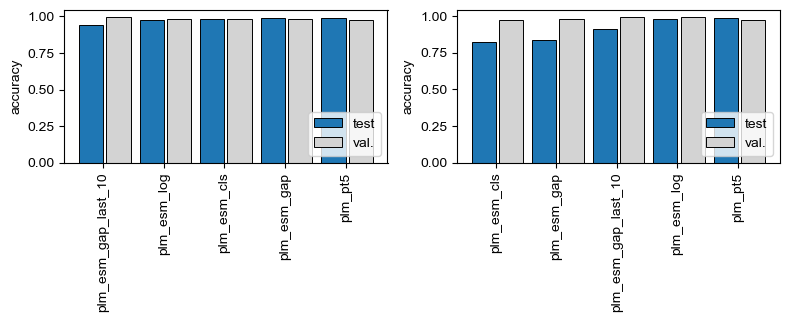

In [117]:
# Want to compare the 2-class to 3-class classifiers for the same feature types, as well as the overall best accuracies. 
# It's probably OK to exclude the benchmarks from the figures, as they aren't that interesting. 

def figure_1(results_2c:dict, results_3c:dict, path:str='../figures/results-figure_1.png', datasets:list=['test', 'val.'], merge:bool=True):
    ''''''
    
    fig = plt.figure(figsize=(8, 5), layout='tight')
    grid = GridSpec(nrows=2, ncols=2, figure=fig)

    ax_a = [fig.add_subplot(grid[0, i]) for i in range(2)]

    for results, n_classes, ax in zip([results_2c, results_3c], [2, 3], ax_a):
        df = get_acc_df(results, n_classes=n_classes, datasets=datasets, merge=merge)
        plot_accs(df.sort_values(by='test', axis=1), ax=ax)
        ax.set_ylabel('accuracy')

    plt.savefig(path)
    plt.show()
        
figure_1(results_2c, results_3c)


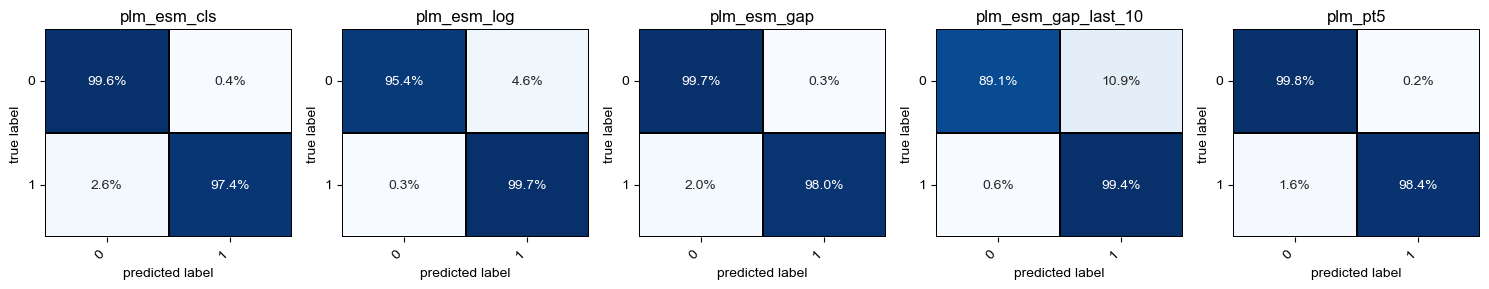

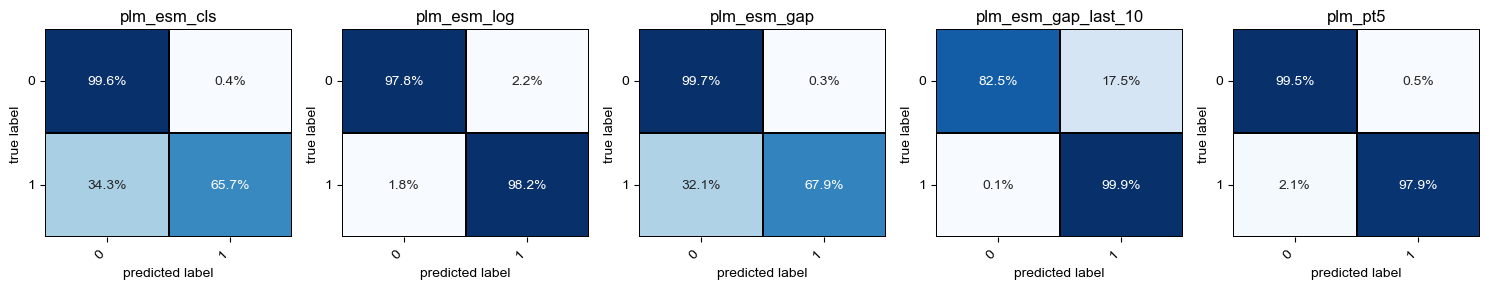

In [ ]:
def figure_2(results:dict, path:str='../figures/results-figure_1.png', merge:bool=True):

    df = results['test'] if (not merge) else merge_labels(results['test'])
    n_classes = df.label.nunique() 

    fig, axes = plt.subplots(ncols=len(feature_types), figsize=(3 * len(feature_types), 3), layout='tight')

    for feature_type, ax in zip(feature_types, axes):
        pred_col = [col for col in df.columns if (f'{feature_type}_prediction' in col)][0]
        preds, labels = df[pred_col].values, df.label.values

        matrix = pd.DataFrame(confusion_matrix(labels, preds), columns=np.arange(n_classes), index=np.arange(n_classes))
        matrix = matrix.apply(lambda x: x/x.sum(), axis=1) # Normalize the matrix.
        sns.heatmap(matrix, ax=ax, cmap='Blues', annot=True, fmt='.1%', cbar=False, linecolor='k', linewidths=0.2) # fmt='.1%',
        # Rotate the tick labels on the x-axis of each subplot.
        ax.set_xticks(np.arange(n_classes) + 0.5, matrix.columns, rotation=45, ha='right')
        ax.set_yticks(np.arange(n_classes) + 0.5, matrix.columns, rotation=0)
        ax.set_xlabel('predicted label')
        ax.set_ylabel('true label')
        ax.set_title(feature_type)
    
    plt.show()

figure_2(results_2c)
figure_2(results_3c)


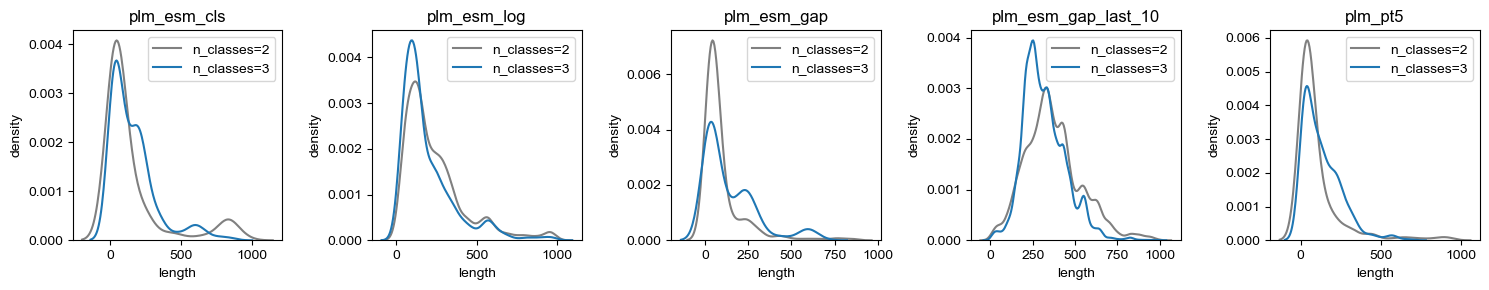

In [ ]:
def figure_3(results_2c:dict, results_3c:dict, path:str='../figures/results-figure_3.png'):
    '''Visualize the length distributions of the sequences predicted to be selenoproteins across all datasets.'''
    dfs = dict()
    dfs[2] = pd.concat(list(results_2c.values()))
    dfs[3] = pd.concat(list(results_3c.values()))

    fig, axes = plt.subplots(ncols=len(feature_types), figsize=(3 * len(feature_types), 3), layout='tight')

    color_map = {2:'gray', 3:'tab:blue'}
    for feature_type, ax in zip(feature_types, axes):

        for n_classes, df in dfs.items():
            df = df[(df[f'model_{n_classes}c_{feature_type}_prediction'] == 1) & (df.label.isin([0, 2]))] # Grab the false positives from the DataFrame. 
            sns.kdeplot(df.seq.apply(len), color=color_map[n_classes], ax=ax, label=f'n_classes={n_classes}')
        
        ax.set_ylabel('density')
        ax.set_xlabel('length')
        ax.legend()
        ax.set_title(feature_type)
    
    plt.show()

figure_3(results_2c, results_3c)


In [122]:
# I should take a look at the training curves and make sure nothing is underfitting, particularly because the ESM model
# has twice as many features...

def plot_training_curve(model_name:str, ax:plt.Axes=None):

    model = Classifier.load(f'../models/{model_name}.pkl')

    x = np.arange(100)
    ax.plot(x, model.model.val_accs[1:], color='tab:blue')
    ax.vlines([model.model.best_epoch], ymin=ax.get_ylim()[0], ymax=1, color='black', ls='--', lw=0.5)
    ax.text(model.model.best_epoch, 1, f'{model.model.best_epoch}', ha='center')

    right_ax = ax.twinx()
    right_ax.plot(x, model.model.train_losses, color='gray')

    ax.set_title(model_name + ' training curve')
    ax.set_ylabel('balanced accuracy')
    right_ax.set_ylabel('weighted CE loss')
    handles = [Patch(facecolor='tab:blue', edgecolor='black', label='val. acc.'), Patch(facecolor='gray', edgecolor='black', label='train. loss.')]
    ax.legend(handles=handles)

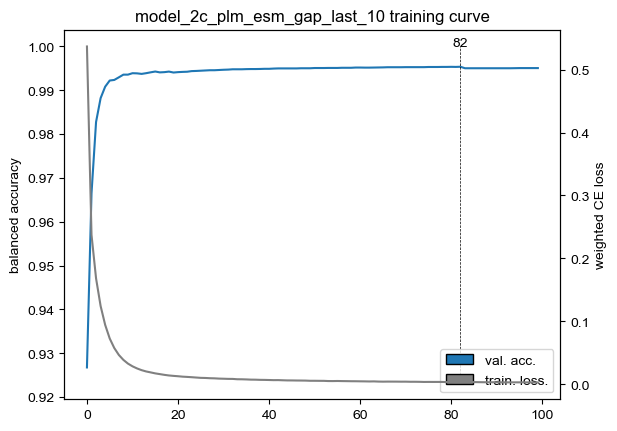

In [99]:
fig, ax = plt.subplots()
plot_training_curve(model_name='model_2c_plm_esm_gap_last_10', ax=ax)
plt.show()